In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
donors_csv = f"./output/donors_state{year}_pred_lastname.csv"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,not
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,bloomberg,not
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,steyer,not
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.513356e+07,23,1.962328e+06,2800.0,mellon,not
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,adelson,not
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,adelson,not
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,3.536433e+07,319,1.108600e+05,2800.0,uihlein,not
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,3.366763e+07,188,1.790832e+05,2800.0,griffin,not
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,not
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,CA,3.308810e+07,914,3.620142e+04,2800.0,jurvetson,not


In [4]:
len(donors)

3588936

In [8]:
print(donors.sort_values(by="total_donated", ascending=False).head(10000)['total_donated'].sum()/donors["total_donated"].sum()*100)
donors.sort_values(by="total_donated", ascending=False).head(10)

52.08035503339197


,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,not
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,bloomberg,not
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,steyer,not
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.513356e+07,23,1.962328e+06,2800.0,mellon,not
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,adelson,not
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,adelson,not
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,3.536433e+07,319,1.108600e+05,2800.0,uihlein,not
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,3.366763e+07,188,1.790832e+05,2800.0,griffin,not
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,not
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,CA,3.308810e+07,914,3.620142e+04,2800.0,jurvetson,not


In [9]:
donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
149,U00000033011,"KHOSLA, VINOD",vinod khosla,Khosla Ventures,NaN,F2500,M,VENTURE CAPITALIST,KHOSLA VENTURES,PORTOLA VALLEY,CA,2410795.0,56,43049.910714,2224.0,khosla,ind
264,m0001327150,"GANDHI, SAMEER",sameer gandhi,Accel Partners,NaN,F2500,M,VENTURE CAPITALIST,ACCEL,SAN FRANCISCO,CA,1629499.0,110,14813.627273,10000.0,gandhi,ind
340,i30032161751,"CHANDI, NACHHATTAR",nachhattar chandi,Chandi Group Usa,NaN,F4100,M,OWNER,CHANDI GROUP USA,INDIO,CA,1311745.0,104,12612.932692,1572.5,chandi,ind
349,h10013502001,"REDDY, PREM",prem reddy,Prime Healthcare Services,NaN,H1100,M,FOUNDER/CHIEF EXECUTIVE OFFICER,PRIME HEALTHCARE SERVICES,VICTORVILLE,CA,1297700.0,59,21994.915254,10000.0,reddy,ind
373,p00053429381,"MANTENA, RAMALINGA",ramalinga mantena,Integra Connect,NaN,H3900,F,SELF-EMPLOYED,INTEGRA CONNECT LLC,JUPITER,FL,1241200.0,45,27582.222222,10000.0,mantena,ind
377,U0000004388A,"MANTENA, PADMAJA",padmaja mantena,Integra Connect,NaN,H3900,F,HOMEMAKER,HOMEMAKER,JUPITER,FL,1235200.0,47,26280.851064,10000.0,mantena,ind
492,h3003465387,"AYYADURAI, SHIVA",shiva ayyadurai,[Candidate Contribution],NaN,Z9000,U,CHAIRMAN & CEO,"CYTOSOLVE, INC.",BELMONT,MA,1044900.0,21,49757.142857,2000.0,ayyadurai,ind
522,U0000004761,"SINGH, NISHAD",nishad singh,FTX.US,NaN,F2800,M,DIRECTOR OF ENGINEERING,ALAMEDA RESEARCH LLC,SAN FRANCISCO,CA,1000000.0,1,1000000.000000,1000000.0,singh,ind
529,h3001220400,"MULYE, NIRMAL",nirmal mulye,Nostrum Pharmaceuticals,NaN,H4300,M,CHAIRMAN,NOSTRUM PHARMACEUTICALS,MIAMI,FL,986499.0,69,14297.086957,7068.0,mulye,ind
611,r0007027508,"SAMBASIVAM, SIVAKAMI",sivakami sambasivam,Goodrx,NaN,H4400,U,NaN,GOODRX,SANTA MONICA,CA,860763.0,238,3616.651261,1190.0,sambasivam,ind


In [10]:
print(donors["total_donated"].sum())
print(donors[donors["ethnic"] == "ind"]["total_donated"].sum())
print((donors[donors["ethnic"] == "ind"]["total_donated"].sum()/donors["total_donated"].sum())*100, "% of donated amount is from diaspora")

12004197961.0
80911468.0
0.6740264386081463 % of donated amount is from diaspora


In [11]:
print(len(donors))
print(len(donors[donors["ethnic"] == "ind"]))
print((len(donors[donors["ethnic"] == "ind"])/len(donors))*100, "% of donors are from diaspora")

3588936
21028
0.5859118134176815 % of donors are from diaspora


In [12]:
print(donors["donation_count"].median())
print(donors[donors["ethnic"] == "ind"]["donation_count"].median())

3.0
2.0


In [13]:
print(donors["total_donated"].median())
print(donors[donors["ethnic"] == "ind"]["total_donated"].median());

432.0
575.0


In [14]:
print(donors["total_donated"].mean())
print(donors[donors["ethnic"] == "ind"]["total_donated"].mean())

3344.7790545721627
3847.796652082937


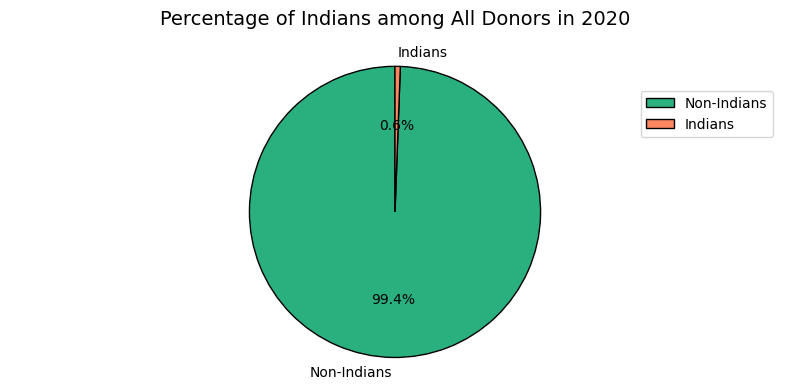

In [15]:
indian_counts = donors['ethnic'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(indian_counts, 
        labels=['Non-Indians', 'Indians'], 
        colors=['#2ab07f', '#fb8761'], 
        autopct='%1.1f%%', 
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 10})

plt.title(f'Percentage of Indians among All Donors in 20{year}', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

In [16]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Unknown                  680118
Party                    457704
Ideology/Single Issue    351066
Health                   306837
Finance                  232336
Tech                     122934
Labor                    106811
Law                       79766
Transportation            75121
Construction              66659
Energy                    58773
Agribusiness              43488
Manufacturing             31758
Defense                   26274
Name: count, dtype: int64

In [19]:
donors[(donors["state"] == "CA") & (donors["ethnic"] == "ind")].groupby("sector")["total_donated"].sum().sort_values(ascending=False)

sector
Finance                  10260995.0
Party                     3799681.0
Health                    3767688.0
Unknown                   1969620.0
Tech                      1251407.0
Ideology/Single Issue      665307.0
Manufacturing              434123.0
Law                        403011.0
Transportation             170794.0
Energy                      99528.0
Construction                76767.0
Agribusiness                65200.0
Defense                     37129.0
Labor                       15611.0
Name: total_donated, dtype: float64

In [24]:
donors[(donors["state"] == "CA") & (donors["ethnic"] == "ind")]["total_donated"].sum()

24053665.0

In [22]:
donors[(donors["ethnic"] == "ind")].groupby("sector")["total_donated"].sum().sort_values(ascending=False)

sector
Finance                  18464983.0
Party                    17448885.0
Health                   13688026.0
Unknown                   8978536.0
Tech                      4623554.0
Ideology/Single Issue     2962542.0
Transportation            1966484.0
Law                       1946614.0
Manufacturing             1929938.0
Construction              1412290.0
Defense                    595704.0
Energy                     503849.0
Agribusiness               323612.0
Labor                       74379.0
Name: total_donated, dtype: float64

In [23]:
donors[(donors["ethnic"] == "ind")]["total_donated"].sum()

80911468.0

In [28]:
donors[(donors["state"] == "CA") & (donors["ethnic"] == "ind")].iloc[:10]

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic,sector
149,U00000033011,"KHOSLA, VINOD",vinod khosla,Khosla Ventures,NaN,F2500,M,VENTURE CAPITALIST,KHOSLA VENTURES,PORTOLA VALLEY,CA,2410795.0,56,43049.910714,2224.0,khosla,ind,Finance
264,m0001327150,"GANDHI, SAMEER",sameer gandhi,Accel Partners,NaN,F2500,M,VENTURE CAPITALIST,ACCEL,SAN FRANCISCO,CA,1629499.0,110,14813.627273,10000.0,gandhi,ind,Finance
340,i30032161751,"CHANDI, NACHHATTAR",nachhattar chandi,Chandi Group Usa,NaN,F4100,M,OWNER,CHANDI GROUP USA,INDIO,CA,1311745.0,104,12612.932692,1572.5,chandi,ind,Finance
349,h10013502001,"REDDY, PREM",prem reddy,Prime Healthcare Services,NaN,H1100,M,FOUNDER/CHIEF EXECUTIVE OFFICER,PRIME HEALTHCARE SERVICES,VICTORVILLE,CA,1297700.0,59,21994.915254,10000.0,reddy,ind,Health
522,U0000004761,"SINGH, NISHAD",nishad singh,FTX.US,NaN,F2800,M,DIRECTOR OF ENGINEERING,ALAMEDA RESEARCH LLC,SAN FRANCISCO,CA,1000000.0,1,1000000.000000,1000000.0,singh,ind,Finance
611,r0007027508,"SAMBASIVAM, SIVAKAMI",sivakami sambasivam,Goodrx,NaN,H4400,U,NaN,GOODRX,SANTA MONICA,CA,860763.0,238,3616.651261,1190.0,sambasivam,ind,Health
765,r0014803404,"ALWAN, KHALID",khalid alwan,Investor,NaN,F7000,M,SELF EMPLOYED,SELF-EMPLOYED,BEVERLY HILLS,CA,721838.0,125,5774.704000,3486.0,alwan,ind,Finance
1540,U00000003781,"RAO, AMY",amy rao,Hillspire LLC,NaN,F7000,F,EXECUTIVE,HILLSPIRE,PALO ALTO,CA,384338.0,73,5264.904110,1000.0,rao,ind,Finance
1586,h3001567123@,"MANI, RACHEL MRS",rachel mrs mani,Mani Brothers Real Estate Group,NaN,F4000,F,INTERIOR DESIGN,SELF-EMPLOYED,WEST HOLLYWOOD,CA,375000.0,12,31250.000000,21950.0,mani,ind,Finance
1848,m0001892517,"MYLAVARAPU, SWATI",swati mylavarapu,[24T Contribution],NaN,Z9500,F,INVESTOR,NOT EMPLOYED,SAN FRANCISCO,CA,331670.0,123,2696.504065,2800.0,mylavarapu,ind,Party


In [31]:
donors[(donors["state"] == "CA") & (donors["ethnic"] == "ind") & (donors["sector"] == "Health")]["occupation"].value_counts()

occupation
PHYSICIAN                             157
PROFESSOR                              26
DOCTOR                                 23
NOT EMPLOYED                           22
DENTIST                                16
                                     ... 
PHARMACY TECHNICIAN                     1
OFFICER                                 1
NEPHROLOGIST                            1
CHIEF MEDICAL OFFICER, HEALTH PLAN      1
RECRUITMENT COORDINATOR                 1
Name: count, Length: 191, dtype: int64

In [32]:
donors[(donors["state"] == "CA") & (donors["ethnic"] == "ind")]["sector"].value_counts()

sector
Party                    913
Unknown                  909
Health                   569
Tech                     416
Ideology/Single Issue    326
Finance                  302
Transportation           143
Law                       90
Energy                    61
Construction              46
Labor                     39
Agribusiness              26
Manufacturing             24
Defense                   19
Name: count, dtype: int64

In [46]:
donors[(donors["state"] == "CA") & (donors["ethnic"] == "ind") & (donors["sector"] == "Health")]

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic,sector
349,h10013502001,"REDDY, PREM",prem reddy,Prime Healthcare Services,NaN,H1100,M,FOUNDER/CHIEF EXECUTIVE OFFICER,PRIME HEALTHCARE SERVICES,VICTORVILLE,CA,1297700.0,59,21994.915254,10000.0,reddy,ind,Health
611,r0007027508,"SAMBASIVAM, SIVAKAMI",sivakami sambasivam,Goodrx,NaN,H4400,U,NaN,GOODRX,SANTA MONICA,CA,860763.0,238,3616.651261,1190.0,sambasivam,ind,Health
2674,n00012990711,"MANI, HAMID",hamid mani,California Retina Assoc,NaN,H1120,M,PHYSICIAN,SELF-EMPLOYED,LA JOLLA,CA,247200.0,12,20600.000000,19350.0,mani,ind,Health
2994,m0001430825,"BHATIA, KAVITHA",kavitha bhatia,Prime Healthcare Services,NaN,H1100,N,CEO STRATEGY,PRIME HEALTHCARE,LOS ANGELES,CA,223994.0,22,10181.545455,10000.0,bhatia,ind,Health
10585,b06085439861,"PATEL, RAVI",ravi patel,Comprehensive Blood & Cancer Center,NaN,H1100,M,PHYSICIAN,CBCC,BAKERSFIELD,CA,75000.0,8,9375.000000,5000.0,patel,ind,Health
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556352,r0001292966,"SAHOTA, AJAYDIP",ajaydip sahota,Kaiser Permanente,NaN,H1750,U,PHARMACIST,KAISER,PLEASANTON,CA,10.0,1,10.000000,10.0,sahota,ind,Health
3559189,q0002210004,"KUMAR, RAMDAS",ramdas kumar,Renal Consultants Medical Group,NaN,H1100,M,PHYSICIAN,RENAL CONSULTANTS,OAK PARK,CA,10.0,1,10.000000,10.0,kumar,ind,Health
3564423,p0005278984,"RAI, DEBRA R",debra r rai,Kaiser Permanente,NaN,H1710,F,REGISTERED NURSE,KAISER PERMANENTE,SANTA CLARA,CA,8.0,1,8.000000,8.0,rai,ind,Health
3581434,p0003298968,"MOHAN, PRARTHANA",prarthana mohan,New York Film Academy,NaN,H5100,F,EDUCATOR,NYFA,SANTA CLARITA,CA,3.0,1,3.000000,3.0,mohan,ind,Health


In [47]:
donors[(donors["name_new"] == "sivakami sambasivam")]

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic,sector
611,r0007027508,"SAMBASIVAM, SIVAKAMI",sivakami sambasivam,Goodrx,NaN,H4400,U,NaN,GOODRX,SANTA MONICA,CA,860763.0,238,3616.651261,1190.0,sambasivam,ind,Health


In [45]:
donors[(donors["ethnic"] == "ind") & (donors["sector"] == "Agribusiness")]["state"].value_counts()

state
CA    26
NC     6
MA     5
VA     5
NY     4
IN     4
GA     4
TX     4
TN     4
IA     4
OH     4
PA     3
MN     2
HI     2
ID     2
IL     2
CO     2
CT     1
MO     1
WV     1
KS     1
OK     1
NE     1
NH     1
WI     1
MD     1
OR     1
DC     1
SD     1
WA     1
KY     1
ND     1
Name: count, dtype: int64

In [41]:
donors[(donors["ethnic"] == "ind") & (donors["sector"] == "Agribusiness")]["total_donated"].sum()

323612.0

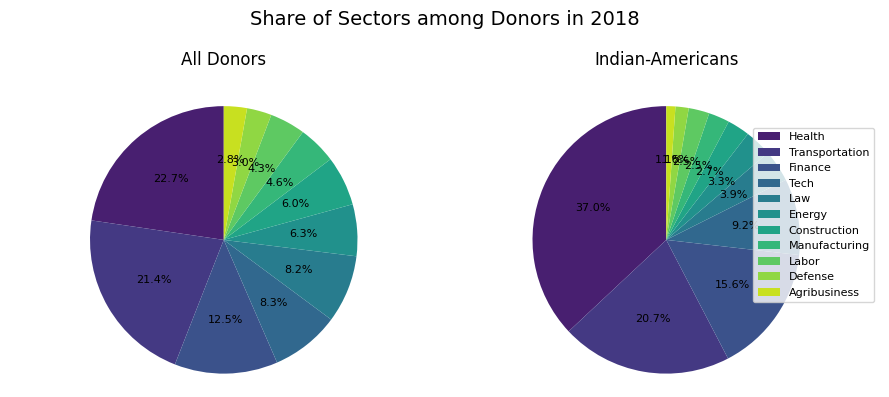

In [14]:
employ_counts = donors['sector'].apply(lambda x: "Other" if x in ["Unknown", "Party", "Ideology/Single Issue"] else x).value_counts().iloc[1:]
employ_counts_indian = donors[donors['ethnic'] == 'ind']['sector'].apply(lambda x: "Other" if x in ["Unknown", "Party", "Ideology/Single Issue"] else x).value_counts().iloc[1:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
wedges1, _, _ = ax1.pie(
    employ_counts,
    labels=None,
    colors=sns.color_palette("viridis", n_colors=len(employ_counts)),
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 8}
)
wedges2, _, _ = ax2.pie(
    employ_counts_indian,
    labels=None,
    colors=sns.color_palette("viridis", n_colors=len(employ_counts_indian)),
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 8}
)

plt.suptitle(f"Share of Sectors among Donors in 20{year}", fontsize=14)
ax1.set_title(f'All Donors', pad=20)
ax1.axis('equal')
ax2.set_title(f'Indian-Americans', pad=20)
ax2.axis('equal')
ax2.legend(wedges2, employ_counts_indian.index, loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=8)

plt.subplots_adjust(wspace=0)
plt.tight_layout()
plt.show()

In [15]:
employ_counts.reset_index().merge(employ_counts_indian.reset_index(), on="sector", how="left", suffixes=('_all', '_ind'))

,sector,count_all,count_ind
0,Health,184067,2659
1,Finance,173607,1118
2,Labor,101290,180
3,Law,67525,278
4,Tech,66568,662
5,Energy,50777,236
6,Transportation,48737,1485
7,Construction,37553,195
8,Agribusiness,34842,79
9,Defense,24309,115


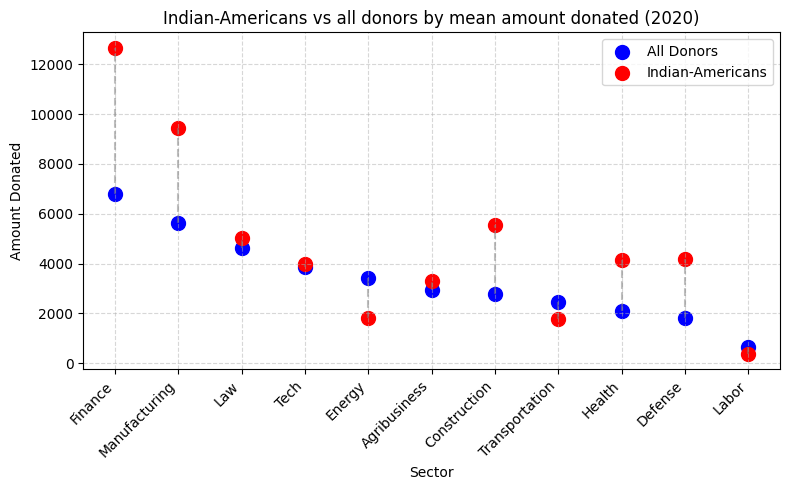

In [16]:
mean_all = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby("sector")["total_donated"].mean().sort_values(ascending=False)
mean_ind = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["total_donated"].mean().sort_values(ascending=False)
sectors = mean_all.index
mean_ind = mean_ind.reindex(sectors, fill_value=0)

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, mean_all, mean_ind):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, mean_all, color='blue', label='All Donors', s=100)
plt.scatter(sectors, mean_ind, color='red', label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs all donors by mean amount donated (20{year})")
plt.xlabel("Sector")
plt.ylabel("Amount Donated")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [17]:
mean_all.apply(lambda x: f"{x:,.0f}").reset_index().merge(mean_ind.apply(lambda x: f"{x:,.0f}").reset_index(), on="sector", how="left", suffixes=('_all', '_ind')).rename(columns={"total_donated_all": "mean_donated_all", "total_donated_ind": "mean_donated_ind"})

,sector,mean_donated_all,mean_donated_ind
0,Finance,"6,795","12,673"
1,Manufacturing,"5,611","9,460"
2,Law,"4,618","5,017"
3,Tech,"3,881","3,986"
4,Energy,"3,403","1,812"
5,Agribusiness,"2,942","3,302"
6,Construction,"2,783","5,538"
7,Transportation,"2,466","1,757"
8,Health,"2,094","4,135"
9,Defense,"1,800","4,195"


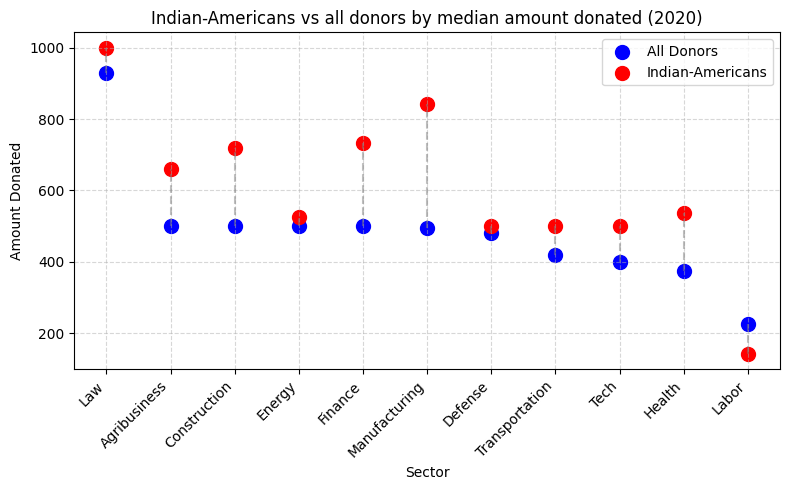

In [18]:
median_all = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby("sector")["total_donated"].median().sort_values(ascending=False)
median_ind = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["total_donated"].median().sort_values(ascending=False)
sectors = median_all.index
median_ind = median_ind.reindex(sectors, fill_value=0)

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, median_all, median_ind):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, median_all, color='blue', label='All Donors', s=100)
plt.scatter(sectors, median_ind, color='red', label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs all donors by median amount donated (20{year})")
plt.xlabel("Sector")
plt.ylabel("Amount Donated")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
median_all.apply(lambda x: f"{x:,.0f}").reset_index().merge(median_ind.apply(lambda x: f"{x:,.0f}").reset_index(), on="sector", how="left", suffixes=('_all', '_ind')).rename(columns={"total_donated_all": "median_donated_all", "total_donated_ind": "median_donated_ind"})

,sector,median_donated_all,median_donated_ind
0,Law,928,"1,000"
1,Agribusiness,500,660
2,Construction,500,720
3,Energy,500,525
4,Finance,500,733
5,Manufacturing,494,842
6,Defense,480,500
7,Transportation,420,501
8,Tech,400,500
9,Health,375,536


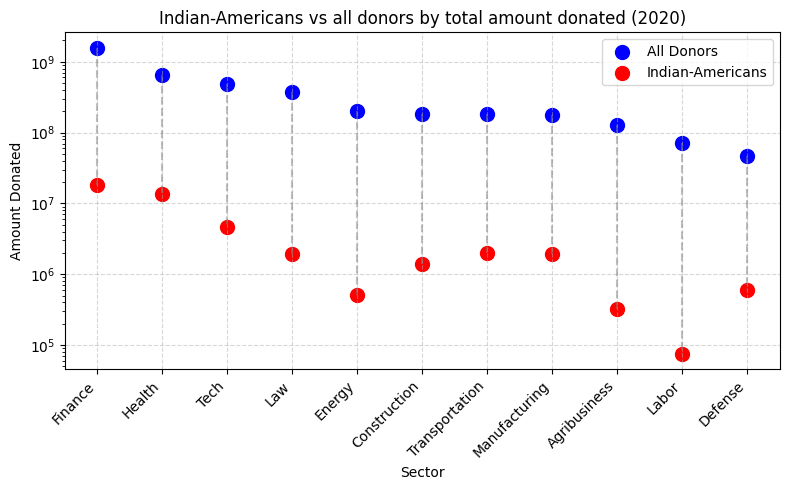

In [20]:
total_all = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby("sector")["total_donated"].sum().sort_values(ascending=False)
total_ind = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["total_donated"].sum().sort_values(ascending=False)
sectors = total_all.index
total_ind = total_ind.reindex(sectors, fill_value=0)

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, total_all, total_ind):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, total_all, color='blue', label='All Donors', s=100)
plt.scatter(sectors, total_ind, color='red', label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs all donors by total amount donated (20{year})")
plt.xlabel("Sector")
plt.ylabel("Amount Donated")
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:
total_all.apply(lambda x: f"{x:,.0f}").reset_index().merge(total_ind.apply(lambda x: f"{x:,.0f}").reset_index(), on="sector", how="left", suffixes=('_all', '_ind'))

,sector,total_donated_all,total_donated_ind
0,Finance,"1,578,607,038","18,464,983"
1,Health,"642,586,765","13,688,026"
2,Tech,"477,098,768","4,623,554"
3,Law,"368,367,439","1,946,614"
4,Energy,"200,029,106","503,849"
5,Construction,"185,504,196","1,412,290"
6,Transportation,"185,240,948","1,966,484"
7,Manufacturing,"178,181,622","1,929,938"
8,Agribusiness,"127,932,856","323,612"
9,Labor,"71,419,239","74,379"


In [22]:
# statistical tests

model = ols('total_donated ~ C(ethnic) + C(sector)', data=donors.drop_duplicates(subset=["contrib_id", "total_donated"])[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq         df          F        PR(>F)
C(ethnic)  3.059847e+10        1.0   2.429242  1.190908e-01
C(sector)  4.450864e+12       10.0  35.335837  7.922729e-70
Residual   1.449466e+16  1150745.0        NaN           NaN


In [23]:
tukey = pairwise_tukeyhsd(endog=donors.drop_duplicates(subset=["contrib_id", "total_donated"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["total_donated"].notnull())]['total_donated'],
                         groups=donors.drop_duplicates(subset=["contrib_id", "total_donated"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["total_donated"].notnull())]['ethnic'],
                         alpha=0.05)
print(tukey.summary())

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff  p-adj   lower     upper  reject
--------------------------------------------------------
   ind    not -1693.8894 0.052 -3402.5157 14.7369  False
--------------------------------------------------------


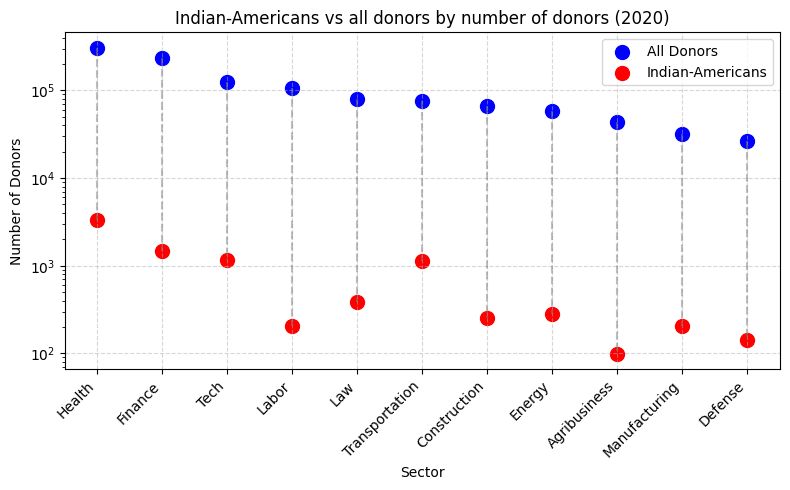

In [24]:
count_all = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby("sector")["total_donated"].count().sort_values(ascending=False)
count_ind = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["total_donated"].count().sort_values(ascending=False)
sectors = count_all.index
count_ind = count_ind.reindex(sectors, fill_value=0)

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, count_all, count_ind):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, count_all, color='blue', label='All Donors', s=100)
plt.scatter(sectors, count_ind, color='red', label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs all donors by number of donors (20{year})")
plt.xlabel("Sector")
plt.ylabel("Number of Donors")
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [25]:
count_all.apply(lambda x: f"{x:,.0f}").reset_index().merge(count_ind.apply(lambda x: f"{x:,.0f}").reset_index(), on="sector", how="left", suffixes=('_all', '_ind')).rename(columns={"total_donated_all": "count_donated_all", "total_donated_ind": "count_donated_ind"})

,sector,count_donated_all,count_donated_ind
0,Health,"306,837","3,310"
1,Finance,"232,336","1,457"
2,Tech,"122,934","1,160"
3,Labor,"106,811",206
4,Law,"79,766",388
5,Transportation,"75,121","1,119"
6,Construction,"66,659",255
7,Energy,"58,773",278
8,Agribusiness,"43,488",98
9,Manufacturing,"31,758",204


In [26]:
state_stats = (
    donors.groupby(["state", "sector"])
    .agg(
        avg_amount=("total_donated", "mean"),
        med_amount=("total_donated", "median"),
        total_donations=("total_donated", "sum"),
        donor_count=("total_donated", "count"),
        avg_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].mean()),
        med_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].median()),
        total_donations_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].sum()),
        donor_count_indian=("ethnic", lambda x: (x == "ind").sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_stats.head(10)

,state,sector,avg_amount,med_amount,total_donations,donor_count,avg_amount_indian,med_amount_indian,total_donations_indian,donor_count_indian
0,CA,Unknown,13371.801337,250.0,1.390132e+09,103960,2166.798680,500.0,1969620.0,909
1,NY,Party,37416.322204,1000.0,1.329065e+09,35521,3441.301746,1000.0,1379962.0,401
2,CA,Party,9238.886828,1000.0,7.317845e+08,79207,4161.753560,1000.0,3799681.0,913
3,NY,Finance,13862.748378,1000.0,3.012514e+08,21731,13464.554264,1000.0,3473855.0,258
4,CA,Finance,10300.775519,558.0,3.009269e+08,29214,33976.804636,1000.0,10260995.0,302
5,CA,Tech,6862.785785,500.0,2.205425e+08,32136,3008.189904,533.5,1251407.0,416
6,FL,Finance,10085.211906,500.0,1.431596e+08,14195,1875.745098,500.0,95663.0,51
7,TX,Party,4364.553908,1000.0,1.430613e+08,32778,4166.876033,1100.0,1512576.0,363
8,CA,Ideology/Single Issue,2101.807827,320.0,1.410334e+08,67101,2040.819018,391.5,665307.0,326
9,CA,Health,2804.066474,352.0,1.233845e+08,44002,6621.595782,600.0,3767688.0,569


In [27]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats, on="state", how="left")

In [28]:
population = pd.read_csv("./data/aapi_population.csv", sep="\t")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2020,Alabama,AL,14673,5033094,0.291530
1,2020,Alaska,AK,0,733017,0.000000
2,2020,Arizona,AZ,62246,7187135,0.866075
3,2020,Arkansas,AR,12461,3014546,0.413362
4,2020,California,CA,856180,39521958,2.166340
5,2020,Colorado,CO,33486,5787129,0.578629
6,2020,Connecticut,CT,61888,3579918,1.728755
7,2020,Delaware,DE,16076,991928,1.620682
8,2020,District of Columbia,DC,176769,670917,26.347372
9,2020,Florida,FL,181805,21592035,0.842000


In [29]:
gdf_merged = gdf_merged.merge(population, left_on="state", right_on="Code", how="left")

In [30]:
most_sector = (
    gdf_merged[~gdf_merged["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])]
    .groupby(["state", "sector"], as_index=False)
    .agg(
        total_donations=("total_donations", "sum"),
        geometry=("geometry", "first")
    )
    .sort_values("total_donations", ascending=False)
    .drop_duplicates("state", keep="first")
)
most_sector = gpd.GeoDataFrame(most_sector, geometry='geometry', crs=gdf_merged.crs)

most_sector_indian = (
    gdf_merged[(~gdf_merged["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"]))]
    .groupby(["state", "sector"], as_index=False)
    .agg(
        total_donations_indian=("total_donations_indian", "sum"),
        geometry=("geometry", "first")
    )
    .sort_values("total_donations_indian", ascending=False)
    .drop_duplicates("state", keep="first")
)
most_sector_indian = gpd.GeoDataFrame(most_sector_indian, geometry='geometry', crs=gdf_merged.crs)

In [31]:
most_sector2 = (
    gdf_merged[~gdf_merged["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"])]
    .groupby(["state", "sector"], as_index=False)
    .agg(
        donor_count=("donor_count", "sum"),
        geometry=("geometry", "first")
    )
    .sort_values("donor_count", ascending=False)
    .drop_duplicates("state", keep="first")
)
most_sector2 = gpd.GeoDataFrame(most_sector2, geometry='geometry', crs=gdf_merged.crs)

most_sector2_indian = (
    gdf_merged[(~gdf_merged["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"]))]
    .groupby(["state", "sector"], as_index=False)
    .agg(
        donor_count_indian=("donor_count_indian", "sum"),
        geometry=("geometry", "first")
    )
    .sort_values("donor_count_indian", ascending=False)
    .drop_duplicates("state", keep="first")
)
most_sector2_indian = gpd.GeoDataFrame(most_sector2_indian, geometry='geometry', crs=gdf_merged.crs)

In [32]:
most_sector2_indian.iloc[0]

state                                                                CA
sector                                                           Health
donor_count_indian                                                  569
geometry              POLYGON ((-114.64222164595688 35.0531061874735...
Name: 38, dtype: object

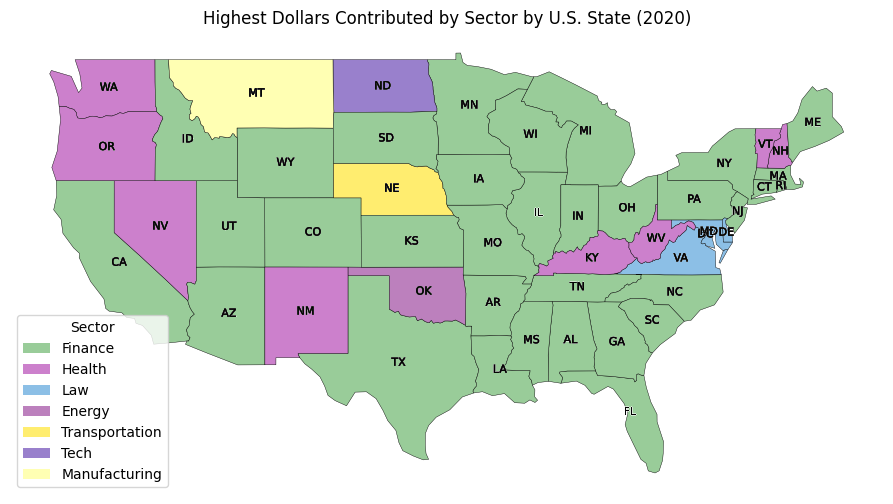

In [33]:
color_map = dict(zip(most_sector_indian["sector"], plt.cm.Set3(np.linspace(0, 1, len(most_sector_indian["sector"])))))
color_map["Tech"] = np.array([0.6, 0.5, 0.8, 1])
color_map["Defense"] = np.array([0.55, 0.75, 0.8, 1])
color_map["Health"] = np.array([0.8, 0.5, 0.8, 1])
color_map["Finance"] = np.array([0.6, 0.8, 0.6, 1])
color_map["Agribusiness"] = np.array([0.8, 0.8, 0.4, 1])
color_map["Law"] = np.array([0.55, 0.75, 0.9, 1])

fig, ax = plt.subplots(figsize=(12, 6))
most_sector.plot(
    column="sector",
    color=[color_map[s] for s in most_sector['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in most_sector["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest Dollars Contributed by Sector by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [34]:
most_sector["sector"].value_counts()

sector
Finance           33
Health             8
Law                4
Energy             1
Transportation     1
Tech               1
Manufacturing      1
Name: count, dtype: int64

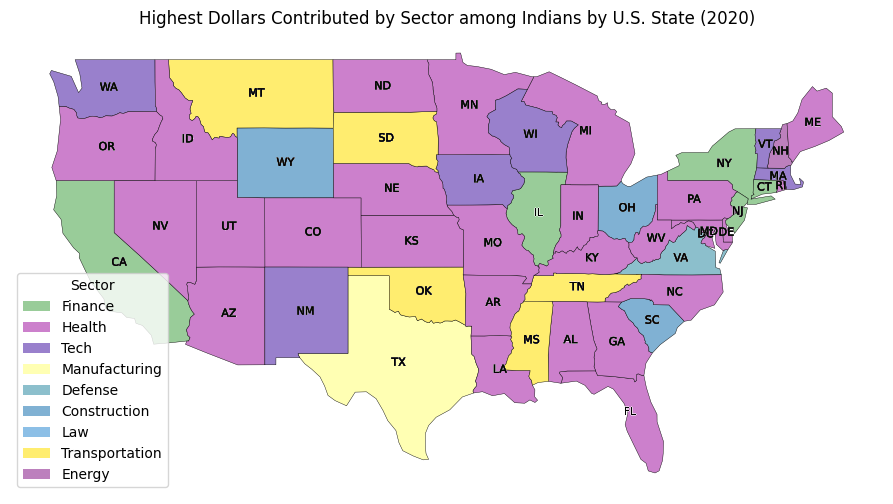

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
most_sector_indian.plot(
    column="sector",
    color=[color_map[s] for s in most_sector_indian['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in most_sector_indian["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest Dollars Contributed by Sector among Indians by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [36]:
most_sector_indian["sector"].value_counts()

sector
Health            26
Tech               6
Finance            5
Transportation     5
Construction       3
Manufacturing      1
Defense            1
Law                1
Energy             1
Name: count, dtype: int64

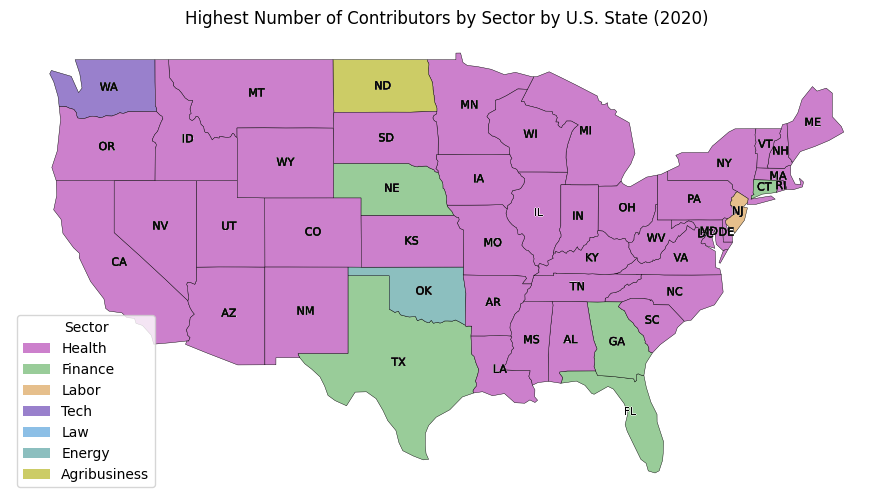

In [37]:
color_map = dict(zip(most_sector2_indian["sector"], plt.cm.Set3(np.linspace(0, 1, len(most_sector2_indian["sector"])))))
color_map["Tech"] = np.array([0.6, 0.5, 0.8, 1])
color_map["Defense"] = np.array([0.55, 0.75, 0.8, 1])
color_map["Health"] = np.array([0.8, 0.5, 0.8, 1])
color_map["Finance"] = np.array([0.6, 0.8, 0.6, 1])
color_map["Agribusiness"] = np.array([0.8, 0.8, 0.4, 1])
color_map["Law"] = np.array([0.55, 0.75, 0.9, 1])
color_map["Labor"] = np.array([0.9, 0.75, 0.55, 1])
color_map["Energy"] = np.array([0.55, 0.75, 0.75, 1])

fig, ax = plt.subplots(figsize=(12, 6))
most_sector2.plot(
    column="sector",
    color=[color_map[s] for s in most_sector2['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in most_sector2["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest Number of Contributors by Sector by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [38]:
most_sector2["sector"].value_counts()

sector
Health          39
Finance          5
Labor            1
Tech             1
Law              1
Energy           1
Agribusiness     1
Name: count, dtype: int64

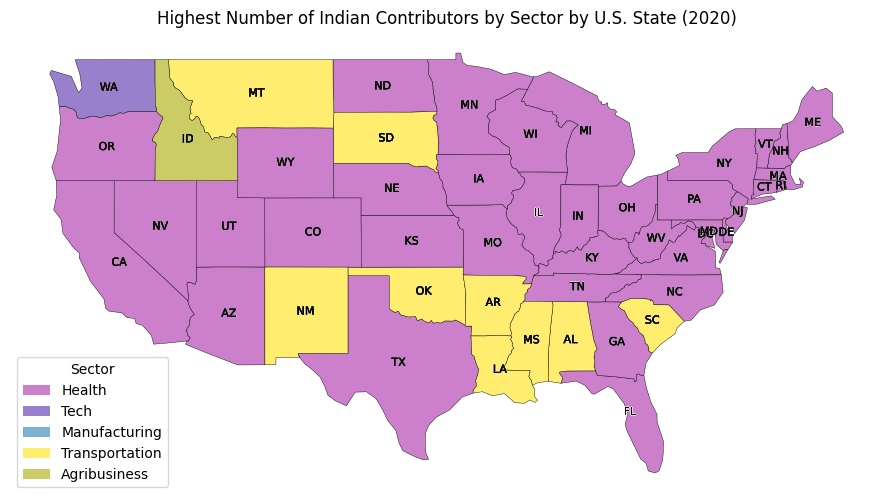

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
most_sector2_indian.plot(
    column="sector",
    color=[color_map[s] for s in most_sector2_indian['sector']],
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
)

legend_elements = [Patch(facecolor=color_map[s], label=s) for s in most_sector2_indian["sector"].unique()]
ax.legend(handles=legend_elements, title='Sector')

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

plt.title(f"Highest Number of Indian Contributors by Sector by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [40]:
most_sector2_indian["sector"].value_counts()

sector
Health            37
Transportation     9
Tech               1
Manufacturing      1
Agribusiness       1
Name: count, dtype: int64

In [41]:
temp = (
    gdf_merged[(~gdf_merged["sector"].isin(["Unknown", "Party", "Other", "Ideology/Single Issue"]))]
    .groupby("state", group_keys=False)  # Keep original index
    .apply(lambda g: g.nlargest(3, "total_donations_indian")) 
    .sort_values("total_donations_indian", ascending=False)
    .reset_index()
)
temp.drop(columns=["geometry"])[temp["state"] == "CA"]

,index,iso_3166_2,name,state,sector,avg_amount,med_amount,total_donations,donor_count,avg_amount_indian,med_amount_indian,total_donations_indian,donor_count_indian,Year,Name,Code,Indian Pop,Census Pop,Share
0,86,US-CA,California,CA,Finance,10300.775519,558.0,300926856.0,29214,33976.804636,1000.0,10260995.0,302,2020,California,CA,856180,39521958,2.16634
2,89,US-CA,California,CA,Health,2804.066474,352.0,123384533.0,44002,6621.595782,600.0,3767688.0,569,2020,California,CA,856180,39521958,2.16634
6,87,US-CA,California,CA,Tech,6862.785785,500.0,220542484.0,32136,3008.189904,533.5,1251407.0,416,2020,California,CA,856180,39521958,2.16634


In [42]:
donors[(donors["state"] == "CA") & (donors["sector"] == "Finance") & (donors["ethnic"] == "ind")].sort_values(by="total_donated", ascending=False).head()

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic,sector
149,U00000033011,"KHOSLA, VINOD",vinod khosla,Khosla Ventures,NaN,F2500,M,VENTURE CAPITALIST,KHOSLA VENTURES,PORTOLA VALLEY,CA,2410795.0,56,43049.910714,2224.0,khosla,ind,Finance
264,m0001327150,"GANDHI, SAMEER",sameer gandhi,Accel Partners,NaN,F2500,M,VENTURE CAPITALIST,ACCEL,SAN FRANCISCO,CA,1629499.0,110,14813.627273,10000.0,gandhi,ind,Finance
340,i30032161751,"CHANDI, NACHHATTAR",nachhattar chandi,Chandi Group Usa,NaN,F4100,M,OWNER,CHANDI GROUP USA,INDIO,CA,1311745.0,104,12612.932692,1572.5,chandi,ind,Finance
522,U0000004761,"SINGH, NISHAD",nishad singh,FTX.US,NaN,F2800,M,DIRECTOR OF ENGINEERING,ALAMEDA RESEARCH LLC,SAN FRANCISCO,CA,1000000.0,1,1000000.000000,1000000.0,singh,ind,Finance
765,r0014803404,"ALWAN, KHALID",khalid alwan,Investor,NaN,F7000,M,SELF EMPLOYED,SELF-EMPLOYED,BEVERLY HILLS,CA,721838.0,125,5774.704000,3486.0,alwan,ind,Finance


In [50]:
sector_stats_indian = (
    donors[~(donors["sector"].isin(["Ideology/Single Issue", "Party", "Unknown"]))].groupby(["state", "sector", "ethnic"])["total_donated"]
    .sum()
    .unstack()
    .fillna(0)
)
sector_stats_indian["total_donated"] = sector_stats_indian.sum(axis=1)
sector_stats_indian = sector_stats_indian.sort_values(by="ind", ascending=False)
sector_stats_indian.iloc[:10]

,ethnic,ind,not,total_donated
state,sector,,,
CA,Finance,10260995.0,290665861.0,300926856.0
FL,Health,3820355.0,42253285.0,46073640.0
CA,Health,3767688.0,119616845.0,123384533.0
NY,Finance,3473855.0,297777530.0,301251385.0
NJ,Finance,1442036.0,24263337.0,25705373.0
MA,Tech,1353944.0,19222336.0,20576280.0
CA,Tech,1251407.0,219291077.0,220542484.0
IL,Finance,1033982.0,95333440.0,96367422.0
NY,Health,1020318.0,49304279.0,50324597.0
